In [243]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from joblib import dump, load
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

In [244]:
sns.set_theme(style="whitegrid", palette="pastel")
pd.set_option('display.max_columns', 500)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

# Обработка исходных данных

### Чтение таблицы

In [245]:
origin_data = pd.ExcelFile('PQM - podatki za pilotni projekt (OCR12VM) - ENG.xlsx')
origin_data.sheet_names

['Table1 (basic)',
 'Table2 (limits)',
 'Table3 (events)',
 'Table4 (alloys)',
 'Table5 (temps)',
 'Table6 (weights)',
 'Table7 (head)',
 'Table8 (scrap)',
 'Table9 (all. scr.)',
 'Table10 (unall. scr.)']

In [246]:
sheet_names = origin_data.sheet_names
table_names = ['basic', 'limits', 'events', 'alloys', 'temps', 'weights', 'head', 'scrap', 'all_scr', 'unall_scr']

In [247]:
data = {}
for sheet_name, table_name in zip(sheet_names, table_names):
    data[table_name] = raw_data.parse(sheet_name, header=1)


In [202]:
data['basic'].head(1)

,HeatNo,Date,QualityRequirement,QualNo,CustID,CustVer,InternalVer,MetalRavneQualityName,SteelGroup,Month,Year,TotalIngotsWeight,PouringScrap,OtherScrap,Last_EOP,Cr_Last_EOP,Cr_Final,LFVD_FeCrA,LFVD_FeCrC,Ni_Last_EOP,Ni_Final,LFVD_NiGran,LFVD_NiKatode,Mo_Last_EOP,Mo_Final,LFVD_FeMo,LFVD_Polymox,V_Last_EOP,V_Final,LFVD_FeV,W_Last_EOP,W_Final,LFVD_FeW72,LFVD_WPaketi
0,71601,2003-08-26 21:12:07,834.99.1 / 2,834,99,1,2,OCR12VM,Tool Steel; High Alloyed; 4 Cold,8,2003,52230.00000,800.00000,1000.00000,NaN,NaN,11.48000,0.00000,1900.00000,NaN,0.11000,0.00000,0.00000,NaN,0.77000,320.00000,0.00000,NaN,0.75000,510.00000,NaN,0.20000,0.00000,0.00000


### Обрабатываем таблицу events

In [248]:
def find_alloy_name(string):
    search_res = re.search(r'Added\s*\[\d+\]\s*([^=]*)', string)
    return search_res.group(1).strip() if search_res else np.nan
def find_alloy_weight(string):
    search_res = re.search(r'Added [^=]*=\s*(-?[\d+,]+)', string)
    return float(search_res.group(1).replace(',', '.')) if search_res else np.nan

In [249]:
data['events']['NameOfAddedAlloy'] = data['events']['EventText'].apply(find_alloy_name)
data['events']['WeightOfAddedAlloy'] = data['events']['EventText'].apply(find_alloy_weight)
data['group_events'] = (
        pd.pivot_table(
            data['events'], 
            index=['HeatNo', 'EventID'], 
            columns='NameOfAddedAlloy',
            values='WeightOfAddedAlloy'
        ).reset_index()
    .groupby('HeatNo', as_index=False)
    .sum()
)

In [250]:
def rename_column(column, prefix):
    return column if column in ['HeatNo', 'EventID'] else prefix + '_'.join([s[0].upper() + s[1:] for s in column.split()])
data['group_events'].columns = [rename_column(column, 'Added_') for column in data['group_events'].columns]

### Обрабатываем таблицу scrap

In [251]:
data['pivot_scrap'] = pd.DataFrame()
for number in range(1, 6 + 1):
    data['pivot_scrap'] = pd.concat([
        data['pivot_scrap'],
        pd.pivot_table(
            data['scrap'], 
            index='HeatNo', 
            columns=f'Fill#{number}_ScrapName',
            values=f'Fill#{number}_ScrapWeight'
        ).reset_index()
    ])
data['pivot_scrap'].columns = [rename_column(column, 'Scrap_') for column in data['pivot_scrap'].columns]
data['pivot_scrap'] = data['pivot_scrap'].groupby('HeatNo', as_index=False).sum()

### Итоговая таблица

In [252]:
columns_for_basic = ['HeatNo', 'Date'] + list(data['basic'].columns[list(data['basic'].columns).index('Month'):])
columns_for_limits = ['HeatNo', 'Date'] + list(data['limits'].columns[list(data['limits'].columns).index('Cr_LowerLimit'):])
res = data['basic'][columns_for_basic].merge(
    data['limits'][columns_for_limits], left_on = ['HeatNo', 'Date'], right_on = ['HeatNo', 'Date'], how='left')

for table in ['group_events', 'alloys', 'temps', 'weights', 'pivot_scrap', 'all_scr', 'unall_scr']:
    res = res.merge(data[table], how='left')
res.isna().sum().sum()

3784

In [253]:
# Избавляемся от дубликатов и проверяем результат
res = (
        res
    .drop_duplicates()
    .drop(columns=[column for column in res.columns if column.endswith('_y')])
    .rename(columns={column: column.replace('_x', '') for column in res.columns if column.endswith('_x')})
)
res.head(3)


,HeatNo,Date,Month,Year,TotalIngotsWeight,PouringScrap,OtherScrap,Last_EOP,Cr_Last_EOP,Cr_Final,LFVD_FeCrA,LFVD_FeCrC,Ni_Last_EOP,Ni_Final,LFVD_NiGran,LFVD_NiKatode,Mo_Last_EOP,Mo_Final,LFVD_FeMo,LFVD_Polymox,V_Last_EOP,V_Final,LFVD_FeV,W_Last_EOP,W_Final,LFVD_FeW72,LFVD_WPaketi,Cr_LowerLimit,Cr_Target,Cr_UpperLimit,Ni_LowerLimit,Ni_Target,Ni_UpperLimit,Mo_LowerLimit,Mo_Target,Mo_UpperLimit,V_LowerLimit,V_Target,V_UpperLimit,W_LowerLimit,W_Target,W_UpperLimit,EventID,Added_Al_Bloki,Added_Al_Gran,Added_Al_Opl.zica,Added_Al_Zica,Added_BOKSIT,Added_BOKSIT_Beli,Added_Borax,Added_CASIfi13,Added_CaO,Added_CaSi,Added_Cfi13,Added_DUŠIK,Added_EPZ_Zlindra,Added_EPŽ_Žlindra,Added_FeAl,Added_FeCrA,Added_FeCrC,Added_FeCrC_Si,Added_FeCrC51,Added_FeCrCSi,Added_FeMnC,Added_FeMo,Added_FeS,Added_FeSi,Added_FeV,Added_FeV_Opl._Žica,Added_FeW72,Added_KARBORITmleti,Added_Kalcijev_Karbid,Added_Mn_Met,Added_Molyquick,Added_Ni_Gran,Added_Ni_Katode,Added_POLYMOX,Added_S_Žica,Added_SINT._ŽLINDRA,Added_SLAGMAG_65B,Added_SiMn,Added_Karburit-kosi,LFVD_AlBloki,LFVD_AlGran,LFVD_Boksit,LFVD_CaO,LFVD_CaSi,LFVD_CASIfi13,LFVD_Cfi13,LFVD_CoMet,LFVD_Cu,LFVD_EPŽŽlindra,LFVD_FeAl,LFVD_FeB,LFVD_FeBŽica,LFVD_FeCrNit,LFVD_FeCrCSi,LFVD_FeCrC51,LFVD_FeMnA,LFVD_FeMnC,LFVD_FeNbTa,LFVD_FeNbTafi13,LFVD_FeS,LFVD_FeSi,LFVD_FeSiZrŽica,LFVD_FeTi,LFVD_FeTifi13,LFVD_KarboritMleti,LFVD_MnMet,LFVD_NiOksid,LFVD_OdpCu,LFVD_SŽica,LFVD_SiMet,LFVD_SiMn,LFVD_SLAGMAG65B,LFVD_KarboritZaVpih,LFVD_Ni90,LFVD_AlŽica,LFVD_Molyquick,LFVD_AlOplašèenaŽica,LFVD_BelaŽlindra,LFVD_Kisik,LFVD_KalcijevKarbid,LFVD_SintŽlindra,LFVD_LastTemperature,LFVD_AlloyWeight,LFVD_NonMetalInclusionsWeight,Scrap_31CRV3,Scrap_CRV,Scrap_E3,Scrap_E6,Scrap_E8,Scrap_OCR12,Scrap_OCR12VM,Scrap_OCR12VM_OSTRUŽKI,Scrap_OH252,Scrap_PK2,Scrap_PK5,Scrap_PK5M,Scrap_PT181,Scrap_UTOPMO2,Scrap_UTOPMO4,Scrap_CRMO_OSTRUŽKI,Scrap_E40,Scrap_OH255,Scrap_VCMO230,Scrap_EMCR,Scrap_OCR12SP,Scrap_OSIKRO3,Scrap_OSIKRO4,Scrap_PT929,Scrap_ECN150,Scrap_UTOP1,Scrap_UTOP2,PV_MKK,PV_PO102,PV_OCR12SPW,PV_OCR8W,PV_PO180,PV_PT181,PV_PT202,PV_PT212,PV_OH239,PV_OSIKRO3,PV_OW4,PV_OCR8VMS,PV_CRV3,PV_OH250,PV_OH252,PV_OH255,PV_OH257,PV_OH258,PV_OH260,PV_OH236NI,PV_UTOPMONI,PV_PKTB,PV_PK3NI,PV_PK332,PV_PK335,PV_PK338,PV_PK340,PV_PK11S,PV_PK343,PV_18MNCR4,PV_PK346,PV_INVAR36,PV_EMCR,PV_SIVA_LITINA,PV_CK10,PV_OC100EX,PV_EC80,PV_VCMO140,PV_VCMO230,PV_31CRV3,PV_ECN150,PV_ECN35,PV_VCNMO200,PV_UTOPNICU,PV_OH807,PV_OCR4PR,PV_OCR12,PV_OCR12SP,PV_OCR12EX,PV_CRV,PV_TMCN2,PV_TMCN1,PV_OSIKRO4,PV_OW1,PV_OCR12VM,PV_CRV2,PV_OSV1,PV_OW6,PV_145V33,PV_UTOP3,PV_UTOPMO2,PV_UTOPEX1,PV_UTOP1,PV_UTOP2,PV_UTOPCO,PV_UTOPEX3,PV_UTOPMO4,PV_UTOPCO2,PV_OV862,PV_UTOPMO6,PV_UTOP33,PV_UTOPSP,PV_UTOPCO3,PV_BRW,PV_BRW1,PV_BRC,PV_BRM2,PV_BRM1,PV_BRM,PV_BRCV,PV_BRC3,PV_BRU,PV_BRCMO,PV_BRCMO2,PV_UTOPTI,PV_12MN,PV_PK2,PV_RAVNIN2,PV_RAVNIN3,PV_RAVNIN4,PV_PK2SP,PV_PK11,PV_PK12,PV_PK13,PV_PKAS,PV_PK15,PV_PK19,PV_PK20,PV_PT929,PV_PK5,PV_PK5M,PV_28304N,PV_PK939,PV_X45,PV_PK942,PV_RAVNAL2,PV_PK10,PV_19MNCR18,PV_214N,PV_OCR8W_OSTRUŽKI,PV_CRV3_OSTRUŽKI,PV_PK335_OSTRUŽKI,PV_CRMO_OSTRUŽKI,PV_CRMO_DROBIŽ,PV_VCNMO200_DROBIŽ,PV_TMCN2_OSTRUŽKI,PV_OCR12VM_OSTRUŽKI,PV_POSEBNA_JEKLA_OSTRUŽKI,PV_BRM2_OSTRUŽKI,PV_E1,PV_E3,PV_E6,PV_E8,PV_Kore,PV_GRODELJ,PV_E40
0,71601,2003-08-26 21:12:07,8,2003,52230.00000,800.00000,1000.00000,NaN,NaN,11.48000,0.00000,1900.00000,NaN,0.11000,0.00000,0.00000,NaN,0.77000,320.00000,0.00000,NaN,0.75000,510.00000,NaN,0.20000,0.00000,0.00000,11.20000,11.46000,12.00000,0,0,0.25000,0.75000,0.78000,0.90000,0.75000,0.80000,0.90000,0,0,0.20000,3158735.00000,15.00000,0.00000,0.00000,0.00000,0.00000,150.00000,0.00000,16.50000,300.00000,0.00000,25.80000,0.00000,100.00000,0.00000,0.00000,0.00000,1900.00000,0.00000,0.00000,0.00000,70.00000,320.00000,0.00000,190.00000,510.00000,0.00000,0.00000,25.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,100.00000,0.00000,0.00000,15.00000,0.00000,150.00000,300.00000,0.00000,16.50000,25.80000,0.00000,0.00000,100.00000,0.00000,0.00000,0.00000,

In [254]:
res.shape

(3591, 280)

# Оценка экономической эффективности

In [255]:
FeCr_columns = ['Added_FeCrCSi', 'Added_FeCrC51', 'Added_FeCrC_Si', 'Added_FeCrC', 'Added_FeCrA']
FeMo_columns = ['Added_FeMo']
FeV_columns = ['Added_FeV', 'Added_FeV_Opl._Žica']
FeW_columns = ['Added_FeW72']
Ni_columns = ['Added_Ni_Gran', 'Added_Ni_Katode']

In [256]:
res['FeCr'] = res[FeCr_columns].sum(axis=1)
res['FeMo'] = res[FeMo_columns].sum(axis=1)
res['FeV'] = res[FeV_columns].sum(axis=1)
res['FeW'] = res[FeW_columns].sum(axis=1)
res['Ni'] = res[Ni_columns].sum(axis=1)

### Суммарное использование химических элементов

In [257]:
used = res[['FeCr', 'FeMo', 'FeV', 'FeW', 'Ni']].sum()
for elem, weight in zip(used.index, used.values):
    print(elem, ': ', int(weight), ' kg', sep='')

FeCr: 2827742 kg
FeMo: 509158 kg
FeV: 1241662 kg
FeW: 159 kg
Ni: 88 kg


In [258]:
for row in data['events'].itertuples():
    if 'Ni' in row.EventText and 'Added' in row.EventText:
        print(row.HeatNo, row.EventText)

86189 Added [55] Ni gran =   73,0 kg
91422 Added [55] Ni gran =   15,0 kg
97123 Added [56] Ni katode =  100,0 kg
97123 Added [56] Ni katode = -100,0 kg


In [259]:
for row in data['events'].itertuples():
    if 'W' in row.EventText and 'Added' in row.EventText:
        print(row.HeatNo, row.EventText)

77376 Added [51] FeW72 =   20,0 kg
79721 Added [51] FeW72 =    5,0 kg
80395 Added [51] FeW72 =    9,0 kg
80943 Added [51] FeW72 =    5,0 kg
83903 Added [51] FeW72 =   90,0 kg
84249 Added [51] FeW72 =   10,0 kg
84249 Added [51] FeW72 =  -10,0 kg
94502 Added [51] FeW72 =   30,0 kg


In [260]:
res.head(1)

,HeatNo,Date,Month,Year,TotalIngotsWeight,PouringScrap,OtherScrap,Last_EOP,Cr_Last_EOP,Cr_Final,LFVD_FeCrA,LFVD_FeCrC,Ni_Last_EOP,Ni_Final,LFVD_NiGran,LFVD_NiKatode,Mo_Last_EOP,Mo_Final,LFVD_FeMo,LFVD_Polymox,V_Last_EOP,V_Final,LFVD_FeV,W_Last_EOP,W_Final,LFVD_FeW72,LFVD_WPaketi,Cr_LowerLimit,Cr_Target,Cr_UpperLimit,Ni_LowerLimit,Ni_Target,Ni_UpperLimit,Mo_LowerLimit,Mo_Target,Mo_UpperLimit,V_LowerLimit,V_Target,V_UpperLimit,W_LowerLimit,W_Target,W_UpperLimit,EventID,Added_Al_Bloki,Added_Al_Gran,Added_Al_Opl.zica,Added_Al_Zica,Added_BOKSIT,Added_BOKSIT_Beli,Added_Borax,Added_CASIfi13,Added_CaO,Added_CaSi,Added_Cfi13,Added_DUŠIK,Added_EPZ_Zlindra,Added_EPŽ_Žlindra,Added_FeAl,Added_FeCrA,Added_FeCrC,Added_FeCrC_Si,Added_FeCrC51,Added_FeCrCSi,Added_FeMnC,Added_FeMo,Added_FeS,Added_FeSi,Added_FeV,Added_FeV_Opl._Žica,Added_FeW72,Added_KARBORITmleti,Added_Kalcijev_Karbid,Added_Mn_Met,Added_Molyquick,Added_Ni_Gran,Added_Ni_Katode,Added_POLYMOX,Added_S_Žica,Added_SINT._ŽLINDRA,Added_SLAGMAG_65B,Added_SiMn,Added_Karburit-kosi,LFVD_AlBloki,LFVD_AlGran,LFVD_Boksit,LFVD_CaO,LFVD_CaSi,LFVD_CASIfi13,LFVD_Cfi13,LFVD_CoMet,LFVD_Cu,LFVD_EPŽŽlindra,LFVD_FeAl,LFVD_FeB,LFVD_FeBŽica,LFVD_FeCrNit,LFVD_FeCrCSi,LFVD_FeCrC51,LFVD_FeMnA,LFVD_FeMnC,LFVD_FeNbTa,LFVD_FeNbTafi13,LFVD_FeS,LFVD_FeSi,LFVD_FeSiZrŽica,LFVD_FeTi,LFVD_FeTifi13,LFVD_KarboritMleti,LFVD_MnMet,LFVD_NiOksid,LFVD_OdpCu,LFVD_SŽica,LFVD_SiMet,LFVD_SiMn,LFVD_SLAGMAG65B,LFVD_KarboritZaVpih,LFVD_Ni90,LFVD_AlŽica,LFVD_Molyquick,LFVD_AlOplašèenaŽica,LFVD_BelaŽlindra,LFVD_Kisik,LFVD_KalcijevKarbid,LFVD_SintŽlindra,LFVD_LastTemperature,LFVD_AlloyWeight,LFVD_NonMetalInclusionsWeight,Scrap_31CRV3,Scrap_CRV,Scrap_E3,Scrap_E6,Scrap_E8,Scrap_OCR12,Scrap_OCR12VM,Scrap_OCR12VM_OSTRUŽKI,Scrap_OH252,Scrap_PK2,Scrap_PK5,Scrap_PK5M,Scrap_PT181,Scrap_UTOPMO2,Scrap_UTOPMO4,Scrap_CRMO_OSTRUŽKI,Scrap_E40,Scrap_OH255,Scrap_VCMO230,Scrap_EMCR,Scrap_OCR12SP,Scrap_OSIKRO3,Scrap_OSIKRO4,Scrap_PT929,Scrap_ECN150,Scrap_UTOP1,Scrap_UTOP2,PV_MKK,PV_PO102,PV_OCR12SPW,PV_OCR8W,PV_PO180,PV_PT181,PV_PT202,PV_PT212,PV_OH239,PV_OSIKRO3,PV_OW4,PV_OCR8VMS,PV_CRV3,PV_OH250,PV_OH252,PV_OH255,PV_OH257,PV_OH258,PV_OH260,PV_OH236NI,PV_UTOPMONI,PV_PKTB,PV_PK3NI,PV_PK332,PV_PK335,PV_PK338,PV_PK340,PV_PK11S,PV_PK343,PV_18MNCR4,PV_PK346,PV_INVAR36,PV_EMCR,PV_SIVA_LITINA,PV_CK10,PV_OC100EX,PV_EC80,PV_VCMO140,PV_VCMO230,PV_31CRV3,PV_ECN150,PV_ECN35,PV_VCNMO200,PV_UTOPNICU,PV_OH807,PV_OCR4PR,PV_OCR12,PV_OCR12SP,PV_OCR12EX,PV_CRV,PV_TMCN2,PV_TMCN1,PV_OSIKRO4,PV_OW1,PV_OCR12VM,PV_CRV2,PV_OSV1,PV_OW6,PV_145V33,PV_UTOP3,PV_UTOPMO2,PV_UTOPEX1,PV_UTOP1,PV_UTOP2,PV_UTOPCO,PV_UTOPEX3,PV_UTOPMO4,PV_UTOPCO2,PV_OV862,PV_UTOPMO6,PV_UTOP33,PV_UTOPSP,PV_UTOPCO3,PV_BRW,PV_BRW1,PV_BRC,PV_BRM2,PV_BRM1,PV_BRM,PV_BRCV,PV_BRC3,PV_BRU,PV_BRCMO,PV_BRCMO2,PV_UTOPTI,PV_12MN,PV_PK2,PV_RAVNIN2,PV_RAVNIN3,PV_RAVNIN4,PV_PK2SP,PV_PK11,PV_PK12,PV_PK13,PV_PKAS,PV_PK15,PV_PK19,PV_PK20,PV_PT929,PV_PK5,PV_PK5M,PV_28304N,PV_PK939,PV_X45,PV_PK942,PV_RAVNAL2,PV_PK10,PV_19MNCR18,PV_214N,PV_OCR8W_OSTRUŽKI,PV_CRV3_OSTRUŽKI,PV_PK335_OSTRUŽKI,PV_CRMO_OSTRUŽKI,PV_CRMO_DROBIŽ,PV_VCNMO200_DROBIŽ,PV_TMCN2_OSTRUŽKI,PV_OCR12VM_OSTRUŽKI,PV_POSEBNA_JEKLA_OSTRUŽKI,PV_BRM2_OSTRUŽKI,PV_E1,PV_E3,PV_E6,PV_E8,PV_Kore,PV_GRODELJ,PV_E40,FeCr,FeMo,FeV,FeW,Ni
0,71601,2003-08-26 21:12:07,8,2003,52230.00000,800.00000,1000.00000,NaN,NaN,11.48000,0.00000,1900.00000,NaN,0.11000,0.00000,0.00000,NaN,0.77000,320.00000,0.00000,NaN,0.75000,510.00000,NaN,0.20000,0.00000,0.00000,11.20000,11.46000,12.00000,0,0,0.25000,0.75000,0.78000,0.90000,0.75000,0.80000,0.90000,0,0,0.20000,3158735.00000,15.00000,0.00000,0.00000,0.00000,0.00000,150.00000,0.00000,16.50000,300.00000,0.00000,25.80000,0.00000,100.00000,0.00000,0.00000,0.00000,1900.00000,0.00000,0.00000,0.00000,70.00000,320.00000,0.00000,190.00000,510.00000,0.00000,0.00000,25.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,100.00000,0.00000,0.00000,15.00000,0.00000,150.00000,300.00000,0.00000,16.50000,25.80000,0.00000,0.00000,100.00000,0.0

Кроме того, для Ni и W во всех плавках целевое содержание = 0%. Но фактическое содержание в среднем равно 0.17% для Ni и 0.05% для W

In [261]:
res.Ni_Target.sum()

0

In [262]:
res.Ni_Final.mean()

0.17833890746933947

In [263]:
res.W_Target.sum()

0

In [264]:
res.W_Final.mean()

0.055150501672242114

### Возможности оптимизации

In [265]:
#Поиск плавок с браком
total_weight = 0
for elem in ['Ni', 'Cr', 'Mo', 'W', 'V']:
    defective = res.query(f"{elem}_Final < {elem}_LowerLimit or {elem}_Final > {elem}_UpperLimit")
    ratio = defective.shape[0] / res.shape[0] * 100
    weight = defective.TotalIngotsWeight.sum()
    total_weight += weight
    
    print(elem)
    print(f"% бракованных плавок: {round(ratio, 2)}")
    print(f"суммарный вес, кг: {int(weight)}")
    print("------------")
print('Общий вес брака, кг:', total_weight)

Ni
% бракованных плавок: 2.09
суммарный вес, кг: 3513540
------------
Cr
% бракованных плавок: 0.67
суммарный вес, кг: 1121890
------------
Mo
% бракованных плавок: 0.72
суммарный вес, кг: 1213615
------------
W
% бракованных плавок: 1.23
суммарный вес, кг: 2075935
------------
V
% бракованных плавок: 1.28
суммарный вес, кг: 2171275
------------
Общий вес брака, кг: 10096255.0


In [266]:
#Поиск плавок на которых предприятие может сэкономить
for elem in ['Ni', 'Cr', 'Mo', 'W', 'V']:
    nonoptimal = res.query(f"{elem}_Final > {elem}_Target and {elem}_Final <= {elem}_UpperLimit").copy()
    nonoptimal['deviation'] = nonoptimal[f"{elem}_Final"] - nonoptimal[f"{elem}_Target"]
    
    print(f"{elem}: Final > Target")
    print(f"доля плавок, %: {round(nonoptimal.shape[0] / res.shape[0] * 100, 4)}")
    print("------------")

Ni: Final > Target
доля плавок, %: 97.8279
------------
Cr: Final > Target
доля плавок, %: 41.2977
------------
Mo: Final > Target
доля плавок, %: 63.687
------------
W: Final > Target
доля плавок, %: 96.9089
------------
V: Final > Target
доля плавок, %: 31.1612
------------


In [267]:
# Смотрим сколько лишнего содержится в плавке, на сколько кг больше и насколько больше предприятие заплатит 
res['Cr_diff'] = res.Cr_Final - res.Cr_Target
res['Mo_diff'] = res.Mo_Final - res.Mo_Target
res['V_diff'] = res.V_Final - res.V_Target
res['W_diff'] = res.W_Final - res.W_Target
res['Ni_diff'] = res.Ni_Final - res.Ni_Target

res['Cr_extra_weight'] = res.Cr_diff / 100 * res.TotalIngotsWeight
res['Mo_extra_weight'] = res.Mo_diff / 100 * res.TotalIngotsWeight
res['V_extra_weight'] = res.V_diff / 100 * res.TotalIngotsWeight
res['W_extra_weight'] = res.W_diff / 100 * res.TotalIngotsWeight
res['Ni_extra_weight'] = res.Ni_diff / 100 * res.TotalIngotsWeight

res['Cr_extra_expenses'] = np.max(res.Cr_extra_weight * 750, 0)
res['Mo_extra_expenses'] = np.max(res.Mo_extra_weight * 5800, 0)
res['V_extra_expenses'] = np.max(res.V_extra_weight * 12500, 0)
res['W_extra_expenses'] = np.max(res.W_extra_weight * 9800, 0)
res['Ni_extra_expenses'] = np.max(res.Ni_extra_weight * 2000, 0)

In [268]:
extra_expenses = res[[f"{elem}_extra_expenses" for elem in ['Cr', 'Mo', 'V', 'W', 'Ni']]].sum()
pd.DataFrame({
    'Элемент': [x.replace('_extra_expenses', '') for x in extra_expenses.index], 
    'Экономия, млн руб': [int(x / 1000000) for x in extra_expenses.values]
})

,Элемент,"Экономия, млн руб"
0,Cr,922
1,Mo,3456
2,V,4018
3,W,7905
4,Ni,1849


## Обработка данных

In [291]:
#Удаление столбцов с нулевыми значениями
zero_columns = [column for column in res.columns[4:] if res[column].sum() == 0]
res = res.drop(columns=zero_columns)

In [292]:
#Проверим сумму столбцов "scrap" и "pv"
res['total_scrap_sum'] = res[[column for column in res.columns if 'scrap' in column]].sum(axis=1)
res['total_pv_sum'] = res[[column for column in res.columns if 'PV' in column]].sum(axis=1)
(res.total_scrap_sum == res.total_pv_sum).sum() == res.shape[0]

False

Сумма равна на всех строках, в обучение модели можно учитывать только scrap (или только pv)

## Подготовка данных для обучения

In [276]:
scrap_columns = [column for column in res.columns if 'scrap' in column and column != 'total_scrap_sum']
common_columns = ['TotalIngotsWeight', 'PouringScrap', 'OtherScrap']

In [277]:
res[common_columns + scrap_columns + ['Cr_Last_EOP', 'Cr_Final', 'FeCr']].isna().sum()

TotalIngotsWeight      7
PouringScrap          22
OtherScrap            30
Cr_Last_EOP          358
Cr_Final               3
FeCr                   0
dtype: int64

In [278]:
datasets = {}

datasets['FeCr'] = res[common_columns + scrap_columns + ['Cr_Last_EOP', 'Cr_Final', 'FeCr']].dropna().copy()
datasets['FeMo'] = res[common_columns + scrap_columns + ['Mo_Last_EOP', 'Mo_Final', 'FeMo']].dropna().copy()
datasets['FeV'] = res[common_columns + scrap_columns + ['V_Last_EOP', 'V_Final', 'FeV']].dropna().copy()
datasets['FeW'] = res[common_columns + scrap_columns + ['W_Last_EOP', 'W_Final', 'FeW']].dropna().copy()
datasets['Ni'] = res[common_columns + scrap_columns + ['Ni_Last_EOP', 'Ni_Final', 'Ni']].dropna().copy()

## Построение моделей  и их обучение 

In [279]:
models = {elem: {} for elem in datasets}

for elem in ['FeCr', 'FeMo', 'FeV', 'FeW', 'Ni']:
    x_columns = sorted([column for column in datasets[elem].columns if column != elem])
    X = datasets[elem][x_columns].to_numpy()
    y = datasets[elem][[elem]].to_numpy().reshape(1, -1)[0]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    print(X.shape)
    
    model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    df = pd.DataFrame({
        'y_test': y_test,
        'y_pred': y_pred
    })  
    df['y_diff'] = df.y_test - df.y_pred
    
    print(elem)
    print('MSE:', round(mean_squared_error(y_test, y_pred, squared=False), 2))
    print('MAE:', round(df.y_diff.sum() / df.shape[0], 2))
    print('----------------')
    
    models[elem]['model'] = model
    models[elem]['df'] = df

(3214, 5)
FeCr
MSE: 353.87
MAE: -10.79
----------------
(3214, 5)
FeMo
MSE: 38.87
MAE: -3.14
----------------
(3214, 5)
FeV
MSE: 53.59
MAE: -0.11
----------------
(3214, 5)
FeW
MSE: 1.1
MAE: -0.08
----------------
(3214, 5)
Ni
MSE: 0.97
MAE: -0.06
----------------


In [280]:
datasets['FeCr']

,TotalIngotsWeight,PouringScrap,OtherScrap,Cr_Last_EOP,Cr_Final,FeCr
383,49440.00000,600.00000,2000.00000,9.71000,11.30000,2400.00000
384,46800.00000,1000.00000,100.00000,12.41000,11.75000,1200.00000
385,45320.00000,800.00000,2000.00000,11.24000,11.63000,2000.00000
386,46800.00000,1000.00000,800.00000,11.87000,11.60000,1450.00000
387,48410.00000,800.00000,2000.00000,10.02000,11.29000,1250.00000
...,...,...,...,...,...,...
3639,47380.00000,800.00000,900.00000,11.09770,11.42000,290.00000
3640,47360.00000,400.00000,900.00000,10.53930,11.30000,516.00000
3641,44400.00000,600.00000,300.00000,9.32720,12.07000,1960.00000
3642,48410.00000,800.00000,700.00000,10.57620,11.29000,650.00000


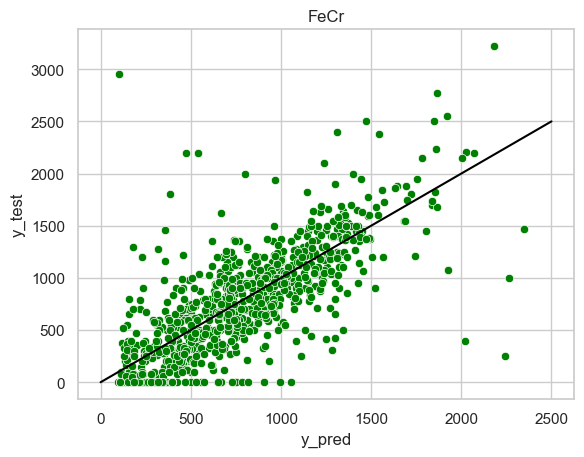

In [281]:
color = sns.color_palette("rocket")[-1]
sns.scatterplot(data=models['FeCr']['df'], x="y_pred", y="y_test", color='green').set(title='FeCr')
plt.plot([0, 2500], [0, 2500], color='black')

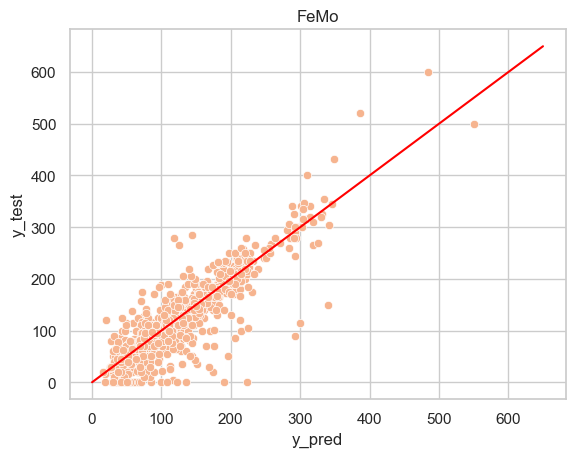

In [282]:
sns.scatterplot(data=models['FeMo']['df'], x="y_pred", y="y_test", color=color).set(title='FeMo')
plt.plot([0, 650], [0, 650], color='red')

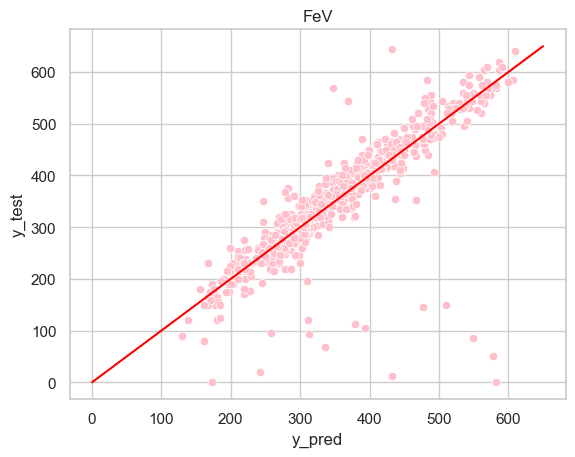

In [283]:
sns.scatterplot(data=models['FeV']['df'], x="y_pred", y="y_test", color='pink').set(title='FeV')
plt.plot([0, 650], [0, 650], color='red')

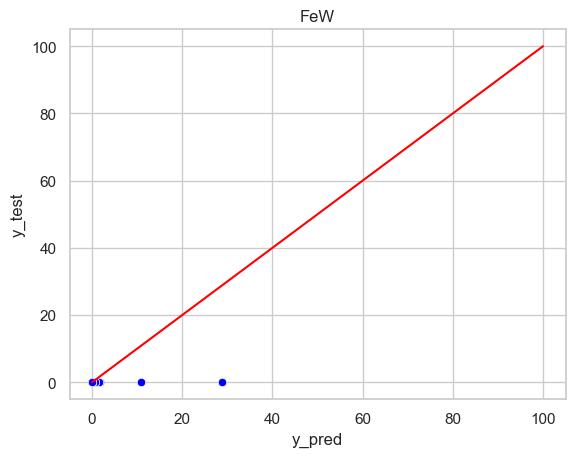

In [284]:
sns.scatterplot(data=models['FeW']['df'], x="y_pred", y="y_test", color='blue').set(title='FeW')
plt.plot([0, 100], [0, 100], color='red')

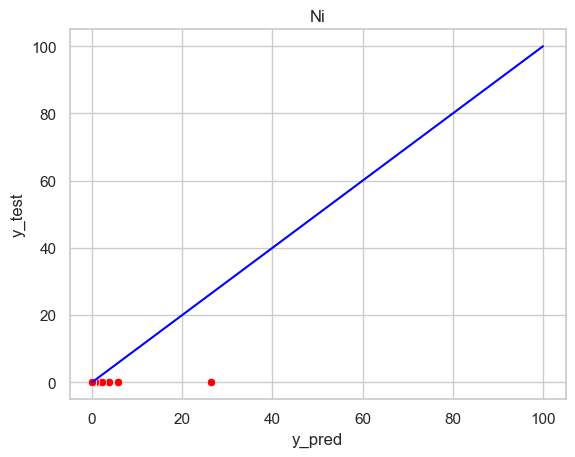

In [285]:
sns.scatterplot(data=models['Ni']['df'], x="y_pred", y="y_test", color='red').set(title='Ni')
plt.plot([0, 100], [0, 100], color='blue')

In [286]:
# Сохранение обученных моделей для приложения
for elem, model in models.items():
    dump(model['model'], f'{elem}_model.joblib')

# Тестовые выборки

In [290]:
columns = {'HeatNo'}
for dataset in datasets.values():
    columns.update(list(dataset.columns))
columns = list(columns)
test_datasets = []
len_datasets = 10
count_datasets = 3
for i in range(1, count_datasets + 1):
    test_datasets.append(res[columns].dropna().sample(n=len_datasets*i, replace=False))
for i in range(count_datasets):
    test_datasets[i].to_csv(f'test_dataset_{i}.csv')